In [7]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [8]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [64]:
import os
import ast

import numpy as np
import pandas as pd

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from SSMuLA.zs_analysis import (
    ZS_OPTS,
    ZS_COMB_OPTS,
    ZS_OPTS_LEGEND,
)

%matplotlib inline

In [10]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]
TOTAL_N_LIST = [n + 96 for n in N_SAMPLE_LIST]

In [14]:
landscape_attribute_df = pd.read_csv("results/merged/merge_landscapeattributes_all.csv")
landscape_attribute_df

,lib,n_site,numb_measured,percent_measured,numb_active,percent_active,active_fit_min,parent_fit,parent_rank,mean,...,top96_SSM_mean_top96,top96_SSM_median_top96,top96_SSM_mean_top384,top96_SSM_median_top384,top96_SSM_fraction_max,top96_SSM_numb_path,numb_loc_opt_norm_cannot_escape,frac_loc_opt_norm_cannot_escape,norm_non-magnitude,norm_reciprocal-sign
0,DHFR,3.0,8000.0,100.000000,854.0,10.675000,0.158614,0.231325,602.0,0.157945,...,1.000000,1.000000,1.000000,1.000000,0.632319,854,1.0,0.000125,4.465397,0.205829
1,ParD2,3.0,7882.0,98.525000,6533.0,82.885055,0.000087,0.973896,12.0,0.228092,...,1.000000,1.000000,1.000000,1.000000,0.722639,6533,1.0,0.000127,28.445324,5.735556
2,ParD3,3.0,7882.0,98.525000,7248.0,91.956356,0.000485,0.982799,7.0,0.321921,...,1.000000,1.000000,1.000000,1.000000,0.178532,7248,1.0,0.000127,28.665219,5.172631
3,GB1,4.0,149361.0,93.350625,34545.0,23.128528,0.001141,0.114130,3644.0,0.009189,...,1.000000,1.000000,1.000000,1.000000,0.025040,34545,2.0,0.000013,9.278868,1.678579
4,T7,3.0,6725.0,84.062500,234.0,3.479554,0.176534,0.288006,163.0,0.016500,...,0.817149,0.772854,0.817149,0.772854,0.017094,234,4.0,0.000595,1.809783,0.547083
5,TEV,4.0,159132.0,99.457500,18262.0,11.476007,0.035601,0.295036,665.0,-0.012509,...,0.943851,1.000000,0.829413,0.810121,0.003395,18262,23.0,0.000145,6.438395,2.381029
6,TrpB3A,3.0,7971.0,99.637500,59.0,0.740183,0.097444,1.000000,1.0,-0.039231,...,0.428916,0.230815,0.428916,0.230815,0.288136,59,3.0,0.000376,0.446493,0.164719
7,TrpB3B,3.0,7996.0,99.950000,18.0,0.225113,0.086085,1.000000,1.0,-0.055223,...,0.274086,0.127970,0.274086,0.127970,0.166667,18,3.0,0.000375,0.122204,0.057886
8,TrpB3C,3.0,7994.0,99.925000,35.0,0.437828,0.207105,1.000000,1.0,-0.073327,...,0.379468,0.315253,0.379468,0.315253,0.114286,35,4.0,0.000500,0.259397,0.101303
9,TrpB3D,3.0,7763.0,97.037500,719.0,9.261883,0.078985,0.820029,10.0,0.018834,...,1.000000,1.000000,0.996377,1.000000,0.393602,719,3.0,0.000386,4.588191,1.260749


In [46]:
alde_dir = "/disk2/fli/alde4ssmula"
eq_ns = [2, 3, 4]
zs_opts = ["esmif", "ev", "coves", "ed", "esm", "Triad", ""]

# write a function to aggregate all the alde results
alde_all = pd.DataFrame(columns=["zs", "rounds", "n_samples", "Protein", "Encoding", "Model", "Acquisition", "Timestep", "Mean", "Std", "Frac"])

for eq_n in eq_ns:

    for zs in zs_opts:

        for n in N_SAMPLE_LIST:

            if zs != "":
                zs_append = f"{zs}_"
                res_append = ""
            else:
                zs_append = ""
                res_append = "_2"

            if eq_n == 1:
                csv_path = f"{alde_dir}/results/{zs_append}all_{str(n)}+96/all_results{res_append}.csv"
                
            else:
                csv_path = f"{alde_dir}/results/{zs_append}{str(eq_n)}eq_{str(int((n+96)/eq_n))}/all_results{res_append}.csv"

            if os.path.exists(csv_path):
                a_df = pd.read_csv(csv_path)
            
                # DNN Ensemble
                # Boosting Ensemble
                slice_df = a_df[a_df["Timestep"] == a_df["Timestep"].max()].copy()

                slice_df["zs"] = zs
                slice_df["rounds"] = eq_n
                slice_df["n_samples"] = n + 96

                # replace T7_2 with T7
                slice_df = slice_df.replace("T7_2", "T7")

                alde_all = alde_all._append(slice_df, ignore_index=True)

            else:
                print(f"File not found: {csv_path}")
                
                alde_all = alde_all._append(
                    {
                        "zs": zs,
                        "rounds": eq_n,
                        "n_samples": n + 96,
                        "Protein": np.nan,
                        "Encoding": np.nan,
                        "Model": np.nan,
                        "Acquisition": np.nan,
                        "Timestep": np.nan,
                        "Mean": np.nan,
                        "Std": np.nan,
                        "Frac": np.nan
                    },
                    ignore_index=True,
                )


/tmp/ipykernel_2190303/3912072052.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  alde_all = alde_all._append(slice_df, ignore_index=True)


File not found: /disk2/fli/alde4ssmula/results/esmif_2eq_240/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/esmif_2eq_336/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/esmif_2eq_528/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/esmif_2eq_1008/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/ev_2eq_240/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/ev_2eq_528/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/ev_2eq_1008/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/coves_2eq_240/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/coves_2eq_1008/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/ed_2eq_528/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/ed_2eq_1008/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/esm_2eq_240/all_results.csv
File not found: /disk2/fli/alde4ssmula/results/esm_2eq_336/all_results.csv
File not found

In [47]:
alde_all

,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
0,esmif,2,120,DHFR,onehot,Boosting Ensemble,GREEDY,120,0.945598,0.009332,0.50
1,esmif,2,120,DHFR,onehot,DNN Ensemble,GREEDY,120,0.970425,0.008095,0.62
2,esmif,2,120,DHFR,Random,Random,GREEDY,120,0.898989,0.011104,0.10
3,esmif,2,120,GB1,onehot,Boosting Ensemble,GREEDY,120,0.585663,0.018376,0.00
4,esmif,2,120,GB1,onehot,DNN Ensemble,GREEDY,120,0.660711,0.021403,0.02
...,...,...,...,...,...,...,...,...,...,...,...
23344,,4,2016,TrpB4,onehot,DNN Ensemble,UCB,2016,0.981373,0.007442,0.88
23345,,4,2016,TrpB4,onehot,GP,GREEDY,2016,0.982239,0.005665,0.80
23346,,4,2016,TrpB4,onehot,GP,TS,2016,0.983631,0.005987,0.84
23347,,4,2016,TrpB4,onehot,GP,UCB,2016,0.983598,0.005582,0.82


In [48]:
sliced_alde = alde_all[
    (alde_all["rounds"] == 4)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == 384)
]
sliced_alde

,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
9621,esmif,4,384,DHFR,onehot,Boosting Ensemble,GREEDY,384,0.997053,0.001843,0.94
9634,esmif,4,384,GB1,onehot,Boosting Ensemble,GREEDY,384,0.830043,0.019505,0.28
9647,esmif,4,384,ParD2,onehot,Boosting Ensemble,GREEDY,384,1.000000,0.000000,1.00
9660,esmif,4,384,ParD3,onehot,Boosting Ensemble,GREEDY,384,0.999546,0.000318,0.96
9673,esmif,4,384,T7,onehot,Boosting Ensemble,GREEDY,384,0.775926,0.007815,0.04
...,...,...,...,...,...,...,...,...,...,...,...
22244,,4,384,TrpB3F,onehot,Boosting Ensemble,GREEDY,384,0.949399,0.028288,0.92
22257,,4,384,TrpB3G,onehot,Boosting Ensemble,GREEDY,384,0.946825,0.023206,0.88
22270,,4,384,TrpB3H,onehot,Boosting Ensemble,GREEDY,384,0.536411,0.063604,0.40
22283,,4,384,TrpB3I,onehot,Boosting Ensemble,GREEDY,384,0.994197,0.005434,0.94


In [49]:
sliced_alde[(sliced_alde["Protein"] == "GB1")]

,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
9634,esmif,4,384,GB1,onehot,Boosting Ensemble,GREEDY,384,0.830043,0.019505,0.28
11714,ev,4,384,GB1,onehot,Boosting Ensemble,GREEDY,384,0.835201,0.016909,0.24
13794,coves,4,384,GB1,onehot,Boosting Ensemble,GREEDY,384,0.769876,0.023013,0.24
15874,ed,4,384,GB1,onehot,Boosting Ensemble,GREEDY,384,0.691217,0.016937,0.08
17954,esm,4,384,GB1,onehot,Boosting Ensemble,GREEDY,384,0.771807,0.022819,0.26
20034,Triad,4,384,GB1,onehot,Boosting Ensemble,GREEDY,384,0.849749,0.021567,0.38
22114,,4,384,GB1,onehot,Boosting Ensemble,GREEDY,384,0.768671,0.017338,0.08


In [50]:
sliced_alde[(sliced_alde["Protein"] == "GB1") & (sliced_alde["zs"] != "")][["Mean", "Frac"]].mean()

Mean    0.791316
Frac    0.246667
dtype: float64

In [51]:
sliced_alde[(sliced_alde["Protein"] == "GB1") & (sliced_alde["zs"] != "")][["Mean", "Frac"]].max()

Mean    0.849749
Frac    0.380000
dtype: float64

In [52]:
ftalde = (
    sliced_alde[sliced_alde["zs"] != ""][["Protein", "Mean", "Frac"]]
    .groupby("Protein")
    .mean()
    .reset_index()
    .rename(columns={"Protein": "lib", "Mean": "zs_top_max", "Frac": "zs_top_frac"})
)
ftalde

,lib,zs_top_max,zs_top_frac
0,DHFR,0.954825,0.686667
1,GB1,0.791316,0.246667
2,ParD2,0.999932,0.993333
3,ParD3,0.997198,0.783333
4,T7,0.777364,0.020000
5,TEV,0.392449,0.000000
6,TrpB3A,0.897537,0.726667
7,TrpB3B,0.427855,0.316667
8,TrpB3C,0.536179,0.293333
9,TrpB3D,0.979860,0.816667


In [53]:
alde = (
    sliced_alde[sliced_alde["zs"] == ""][["Protein", "Mean", "Frac"]]
    .groupby("Protein")
    .mean()
    .reset_index()
    .rename(columns={"Protein": "lib", "Mean": "top_max", "Frac": "frac"})
)
alde

,lib,top_max,frac
0,DHFR,0.934166,0.48
1,GB1,0.768671,0.08
2,ParD2,0.999476,0.94
3,ParD3,0.996783,0.74
4,T7,0.810759,0.00
5,TEV,0.433022,0.04
6,TrpB3A,0.647764,0.50
7,TrpB3B,0.235764,0.12
8,TrpB3C,0.364851,0.04
9,TrpB3D,0.963345,0.62


In [57]:
alde_la = pd.merge(pd.merge(landscape_attribute_df, alde, on="lib"), ftalde, on="lib")
alde_la

,lib,n_site,numb_measured,percent_measured,numb_active,percent_active,active_fit_min,parent_fit,parent_rank,mean,...,top96_SSM_fraction_max,top96_SSM_numb_path,numb_loc_opt_norm_cannot_escape,frac_loc_opt_norm_cannot_escape,norm_non-magnitude,norm_reciprocal-sign,top_max,frac,zs_top_max,zs_top_frac
0,DHFR,3.0,8000.0,100.000000,854.0,10.675000,0.158614,0.231325,602.0,0.157945,...,0.632319,854,1.0,0.000125,4.465397,0.205829,0.934166,0.48,0.954825,0.686667
1,ParD2,3.0,7882.0,98.525000,6533.0,82.885055,0.000087,0.973896,12.0,0.228092,...,0.722639,6533,1.0,0.000127,28.445324,5.735556,0.999476,0.94,0.999932,0.993333
2,ParD3,3.0,7882.0,98.525000,7248.0,91.956356,0.000485,0.982799,7.0,0.321921,...,0.178532,7248,1.0,0.000127,28.665219,5.172631,0.996783,0.74,0.997198,0.783333
3,GB1,4.0,149361.0,93.350625,34545.0,23.128528,0.001141,0.114130,3644.0,0.009189,...,0.025040,34545,2.0,0.000013,9.278868,1.678579,0.768671,0.08,0.791316,0.246667
4,T7,3.0,6725.0,84.062500,234.0,3.479554,0.176534,0.288006,163.0,0.016500,...,0.017094,234,4.0,0.000595,1.809783,0.547083,0.810759,0.00,0.777364,0.020000
5,TEV,4.0,159132.0,99.457500,18262.0,11.476007,0.035601,0.295036,665.0,-0.012509,...,0.003395,18262,23.0,0.000145,6.438395,2.381029,0.433022,0.04,0.392449,0.000000
6,TrpB3A,3.0,7971.0,99.637500,59.0,0.740183,0.097444,1.000000,1.0,-0.039231,...,0.288136,59,3.0,0.000376,0.446493,0.164719,0.647764,0.50,0.897537,0.726667
7,TrpB3B,3.0,7996.0,99.950000,18.0,0.225113,0.086085,1.000000,1.0,-0.055223,...,0.166667,18,3.0,0.000375,0.122204,0.057886,0.235764,0.12,0.427855,0.316667
8,TrpB3C,3.0,7994.0,99.925000,35.0,0.437828,0.207105,1.000000,1.0,-0.073327,...,0.114286,35,4.0,0.000500,0.259397,0.101303,0.364851,0.04,0.536179,0.293333
9,TrpB3D,3.0,7763.0,97.037500,719.0,9.261883,0.078985,0.820029,10.0,0.018834,...,0.393602,719,3.0,0.000386,4.588191,1.260749,0.963345,0.62,0.979860,0.816667


In [58]:
active_cutoff = 1
active_lib_list = alde_la[(alde_la["percent_active"]>active_cutoff)]["lib"].tolist() # & (lib_stat["percent_measured"]>90)
active_lib_list

['DHFR',
 'ParD2',
 'ParD3',
 'GB1',
 'T7',
 'TEV',
 'TrpB3D',
 'TrpB3E',
 'TrpB3F',
 'TrpB3G',
 'TrpB3I',
 'TrpB4']

In [59]:
merge_df = alde_la[alde_la["lib"].isin(active_lib_list)]
merge_df

,lib,n_site,numb_measured,percent_measured,numb_active,percent_active,active_fit_min,parent_fit,parent_rank,mean,...,top96_SSM_fraction_max,top96_SSM_numb_path,numb_loc_opt_norm_cannot_escape,frac_loc_opt_norm_cannot_escape,norm_non-magnitude,norm_reciprocal-sign,top_max,frac,zs_top_max,zs_top_frac
0,DHFR,3.0,8000.0,100.000000,854.0,10.675000,0.158614,0.231325,602.0,0.157945,...,0.632319,854,1.0,0.000125,4.465397,0.205829,0.934166,0.48,0.954825,0.686667
1,ParD2,3.0,7882.0,98.525000,6533.0,82.885055,0.000087,0.973896,12.0,0.228092,...,0.722639,6533,1.0,0.000127,28.445324,5.735556,0.999476,0.94,0.999932,0.993333
2,ParD3,3.0,7882.0,98.525000,7248.0,91.956356,0.000485,0.982799,7.0,0.321921,...,0.178532,7248,1.0,0.000127,28.665219,5.172631,0.996783,0.74,0.997198,0.783333
3,GB1,4.0,149361.0,93.350625,34545.0,23.128528,0.001141,0.114130,3644.0,0.009189,...,0.025040,34545,2.0,0.000013,9.278868,1.678579,0.768671,0.08,0.791316,0.246667
4,T7,3.0,6725.0,84.062500,234.0,3.479554,0.176534,0.288006,163.0,0.016500,...,0.017094,234,4.0,0.000595,1.809783,0.547083,0.810759,0.00,0.777364,0.020000
5,TEV,4.0,159132.0,99.457500,18262.0,11.476007,0.035601,0.295036,665.0,-0.012509,...,0.003395,18262,23.0,0.000145,6.438395,2.381029,0.433022,0.04,0.392449,0.000000
9,TrpB3D,3.0,7763.0,97.037500,719.0,9.261883,0.078985,0.820029,10.0,0.018834,...,0.393602,719,3.0,0.000386,4.588191,1.260749,0.963345,0.62,0.979860,0.816667
10,TrpB3E,3.0,7964.0,99.550000,161.0,2.021597,0.041910,0.610622,5.0,0.002082,...,0.229814,161,3.0,0.000377,1.266380,0.510114,0.478813,0.42,0.886031,0.840000
11,TrpB3F,3.0,7737.0,96.712500,82.0,1.059842,0.092374,1.000000,1.0,-0.023140,...,0.743902,82,1.0,0.000129,0.568209,0.195413,0.949399,0.92,1.000000,1.000000
12,TrpB3G,3.0,7891.0,98.637500,108.0,1.368648,0.072712,0.519956,13.0,-0.002391,...,0.500000,108,1.0,0.000127,0.710907,0.164029,0.946825,0.88,0.989849,0.956667


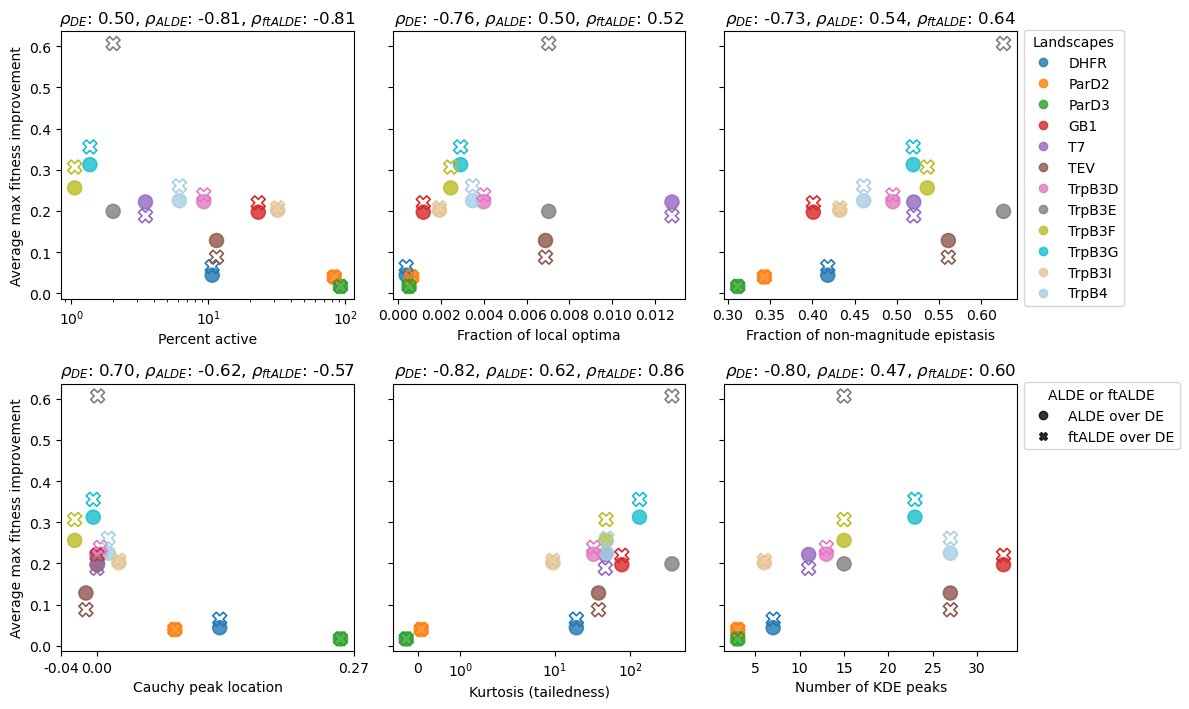

In [67]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7.2), sharey=True)

y = merge_df["top_max"] - merge_df["single_step_DE_mean_all"]
y2 = merge_df["zs_top_max"] - merge_df["single_step_DE_mean_all"]
clist = sns.color_palette("tab10").as_hex() + ['#e5c494', '#a6cee3']
# factors = {"fraction_non-magnitude": , "percent_active": "Percent active", "frac_loc_opt_total": "Fraction of local optima"}

# Scatter plot on the first axes
# ax[0].errorbar(merge_df["fraction_non-magnitude"], y, yerr=de_std, fmt='o', c="gray", markersize=2)

# Scatter plot on the second axes
ax[0, 0].scatter(merge_df["percent_active"], y, c=clist, s=100, alpha=0.8, linewidth=1.2)
ax[0, 0].scatter(
    merge_df["percent_active"],
    y2,
    edgecolors=clist,
    facecolors="none",
    s=100,
    marker="X",
    linewidth=1.2,
)
ax[0, 0].set_xscale("log")
# ax[1].set_xlabel('fraction_non_magnitude')
ax[0, 0].set_xlabel("Percent active")

ax[0, 0].set_ylabel("Average max fitness improvement")
# ax[1].set_title('fraction_non-magnitude vs delta ALDE and DE max fitness achieved')
# ax[1].set_title(r'Spearmanr $\rho$: {:.2f}'.format(spearmanr(y, merge_df["percent_active"])[0]))
ax[0, 0].set_title(
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE}}$: {:.2f}, $\rho_{{ftALDE}}$: {:.2f}".format(
        spearmanr(merge_df["single_step_DE_mean_all"], merge_df["percent_active"])[0],
        spearmanr(y, merge_df["percent_active"])[0],
        spearmanr(y2, merge_df["percent_active"])[0],
    )
)

# Scatter plot on the third axes
ax[0, 1].scatter(merge_df["frac_loc_opt_total"], y, c=clist, s=100, alpha=0.8, linewidth=1.2)
ax[0, 1].scatter(
    merge_df["frac_loc_opt_total"],
    y2,
    edgecolors=clist,
    facecolors="none",
    s=100,
    linewidth=1.2,
    marker="X",
)
ax[0, 1].set_xlabel("Fraction of local optima")
# ax[2].set_title(r'Spearmanr $\rho$: {:.2f}'.format(spearmanr(y, merge_df["frac_loc_opt_total"])[0]))
ax[0, 1].set_title(
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE}}$: {:.2f}, $\rho_{{ftALDE}}$: {:.2f}".format(
        spearmanr(merge_df["single_step_DE_mean_all"], merge_df["frac_loc_opt_total"])[0],
        spearmanr(y, merge_df["frac_loc_opt_total"])[0],
        spearmanr(y2, merge_df["frac_loc_opt_total"])[0],
    )
)

ax[0, 2].scatter(
    merge_df["fraction_non-magnitude"], y, c=clist, s=100, alpha=0.8, linewidth=1.2
)
ax[0, 2].scatter(
    merge_df["fraction_non-magnitude"],
    y2,
    edgecolors=clist,
    facecolors="none",
    s=100,
    marker="X",
    linewidth=1.2,
)
ax[0, 2].set_xlabel("Fraction of non-magnitude epistasis")
ax[0, 2].set_title(
    # de rho corr_df[corr_df["descriptor"]=="fraction_non-magnitude"]["single_step_DE_mean_all"].values[0]
    # r'$\rho_{sub} = \frac{\alpha_{i}}{\beta^{2}_{i+1}}$ for $i = 1, 2, 3$'
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE}}$: {:.2f}, $\rho_{{ftALDE}}$: {:.2f}".format(
        spearmanr(merge_df["single_step_DE_mean_all"], merge_df["fraction_non-magnitude"])[0],
        spearmanr(y, merge_df["fraction_non-magnitude"])[0],
        spearmanr(y2, merge_df["fraction_non-magnitude"])[0],
    )
)


# Scatter plot on the second axes
ax[1, 0].scatter(merge_df["loc"], y, c=clist, s=100, alpha=0.8, linewidth=1.2)
ax[1, 0].scatter(
    merge_df["loc"],
    y2,
    edgecolors=clist,
    facecolors="none",
    s=100,
    marker="X",
    linewidth=1.2,
)
ax[1, 0].set_xscale("symlog")
# ax[1].set_xlabel('fraction_non_magnitude')
ax[1, 0].set_xlabel("Cauchy peak location")
ax[1, 0].set_ylabel("Average max fitness improvement")
# ax[1].set_title('fraction_non-magnitude vs delta ALDE and DE max fitness achieved')
# ax[1].set_title(r'Spearmanr $\rho$: {:.2f}'.format(spearmanr(y, merge_df["percent_active"])[0]))
ax[1, 0].set_title(
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE}}$: {:.2f}, $\rho_{{ftALDE}}$: {:.2f}".format(
        spearmanr(merge_df["single_step_DE_mean_all"], merge_df["loc"])[0],
        spearmanr(y, merge_df["loc"])[0],
        spearmanr(y2, merge_df["loc"])[0],
    )
)
ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


ax[1, 1].scatter(
    merge_df["kurt"], y, c=clist, s=100, alpha=0.8, linewidth=1.2
)
ax[1, 1].scatter(
    merge_df["kurt"],
    y2,
    edgecolors=clist,
    facecolors="none",
    s=100,
    marker="X",
    linewidth=1.2,
)
ax[1, 1].set_xlabel("Kurtosis (tailedness)")
ax[1, 1].set_xscale("symlog")
ax[1, 1].set_title(
    # r"ALDE $\rho$: {:.2f}, ftALDE $\rho$: {:.2f}".format(
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE}}$: {:.2f}, $\rho_{{ftALDE}}$: {:.2f}".format(
        spearmanr(merge_df["single_step_DE_mean_all"], merge_df["kurt"])[0],
        spearmanr(y, merge_df["kurt"])[0],
        spearmanr(y2, merge_df["kurt"])[0],
    )
)

# Scatter plot on the third axes
ax[1, 2].scatter(merge_df["numb_kde_peak"], y, c=clist, s=100, alpha=0.8, linewidth=1.2)
ax[1, 2].scatter(
    merge_df["numb_kde_peak"],
    y2,
    edgecolors=clist,
    facecolors="none",
    s=100,
    linewidth=1.2,
    marker="X",
)
ax[1, 2].set_xlabel("Number of KDE peaks")
# ax[2].set_title(r'Spearmanr $\rho$: {:.2f}'.format(spearmanr(y, merge_df["frac_loc_opt_total"])[0]))
ax[1, 2].set_title(
    # r"ALDE $\rho$: {:.2f}, ftALDE $\rho$: {:.2f}".format(
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE}}$: {:.2f}, $\rho_{{ftALDE}}$: {:.2f}".format(
        spearmanr(merge_df["single_step_DE_mean_all"], merge_df["numb_kde_peak"])[0],
        spearmanr(y, merge_df["numb_kde_peak"])[0],
        spearmanr(y2, merge_df["numb_kde_peak"])[0],
    )
)

legend_list = []  # To store legend handles
legend_list2 = []

for l, lc in zip(merge_df["lib"], clist):
    legend_list.append(
        Line2D([0], [0], marker="o", linestyle="none", color=lc, label=l, alpha=0.8)
    )
ax[0, 2].legend(handles=legend_list, loc="upper left",title="Landscapes",bbox_to_anchor=(1, 1.0325))

for marker, label in zip(["o", "X"], ["ALDE", "ftALDE"]):
    legend_list2.append(
        Line2D(
            [0],
            [0],
            marker=marker,
            linestyle="none",
            color="black",
            alpha=0.8,
            label=f"{label} over DE",
        )
    )
ax[1, 2].legend(handles=legend_list2, loc="upper left",title="ALDE or ftALDE",bbox_to_anchor=(1, 1.0315))


# ax[2].set_xlabel('ALDE and DE max fitness achieved')
# fig.suptitle(
#     "(ft)ALDE Improvemence Over DE Across 10 Minimally Active Landscapes",
#     fontsize=12,
#     fontweight="bold",
#     y=0.975,
# )
# Show plot
plt.tight_layout()
plt.show()